# Clustering counties by deaths
Factoring in the shape of the cumulative deaths trajectory.

In [136]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and process data

In [174]:
# Static data
counties, counties_date = load_counties()

In [175]:
deaths_df = get_cum_deaths_dataframe(n_days=28, onset_threshold=3, time_series=True)
days = [d for d in deaths_df.columns if d[:4] == 'day_']

In [176]:
deaths_df.columns

Index(['FIPS', 'day_01', 'day_02', 'day_03', 'day_04', 'day_05', 'day_06',
       'day_07', 'day_08', 'day_09', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'onset', 'Beds', 'HospCt', 'OD_baseline', 'OD_at_onset',
       'OD_2wk_before_onset', 'OD_2wk_after_onset',
       'Rural-urban_Continuum Code_2013',
       'Density per square mile of land area - Population',
       'Percent of adults with less than a high school diploma 2014-18',
       'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus',
       'POP_ESTIMATE_2018'],
      dtype='object')

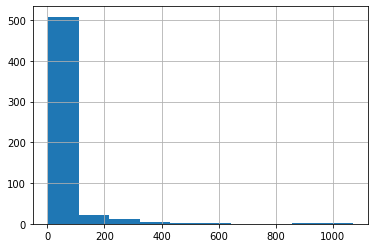

In [197]:
deaths_df[days[-1]].hist()#.transform('log').hist()

In [200]:
UPPER_CUTOFF = 400
LOWER_CUTOFF = 10

ddf = deaths_df.copy()
ddf = ddf[ddf[days[-1]] >= LOWER_CUTOFF]
ddf = ddf[ddf[days[-1]] <= UPPER_CUTOFF]
ddf[days] = ddf[days].divide(ddf['POP_ESTIMATE_2018'], axis=0)
print(ddf.shape)

(357, 43)


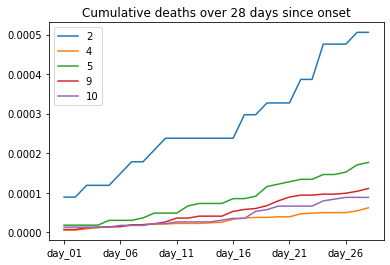

In [201]:
ddf[days][:5].T.plot(title='Cumulative deaths over 28 days since onset')

## Dynamic Time Warping Clustering

In [202]:
def DTWDistance(s1, s2,w=3):
    s1 = s1[s1 >= 0]
    s2 = s2[s2 >= 0]
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [203]:
compute_dists = True
save_dists = True

In [216]:
#X = ddf[days].values
X = ddf[days].diff(
    1, axis=1
).rolling(
    7, center=True, axis=1
).mean(
).dropna(
    axis=1
).values
y = ddf['FIPS'].values

In [205]:
X.shape

(357, 21)

In [206]:
file_name = 'dtw_distmat_18-rp'
if compute_dists:
    X_dists = pairwise_distances(X, metric=DTWDistance)
    if save_dists:
        np.save(f'../data/intermediates/{file_name}', X_dists)
else:
    distmat = np.load(f'../data/intermediates/{file_name}.npy')

In [207]:
linkage = 'average'
n_clusters = np.arange(2,10,1)
for n_clusters in n_clusters:
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage,
        affinity='precomputed'
    ).fit(X_dists)
    score = silhouette_score(X_dists, clustering.labels_, metric='precomputed')
    print(f'{n_clusters}: {score}')

2: 0.7201535304557858
3: 0.7089615218629703
4: 0.6542581573190892
5: 0.644758795849521
6: 0.6374698087133513
7: 0.6365709982010337
8: 0.6338652775912699
9: 0.6269605655240776


In [208]:
def plot(labels, label, n = 5, show=True):
    idxs = np.where(labels == label)[0][:n]
    n = min(len(idxs), n)
    fig,axes = plt.subplots(n,1,figsize=(1.5*5,1.5*n), sharex=True)
    if n == 1:
        axes = [axes]
    for i,idx in enumerate(idxs):
        y = X[idx]
        FIPS = ddf.iloc[idx]['FIPS']
        l = ', '.join(counties[counties['FIPS'] == FIPS][['Area_Name', 'State']].values[0])
        axes[i].plot(np.arange(len(y)), y, label=l)
        axes[i].legend(loc='upper left')
    axes[0].set_title(f'Cluster {label+1}, Size={len(np.where(labels == label)[0])}')
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.savefig(f'../figures/dtw_cluster-{label+1}.pdf')
    plt.close()

In [209]:
clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage, affinity='precomputed').fit(X_dists)

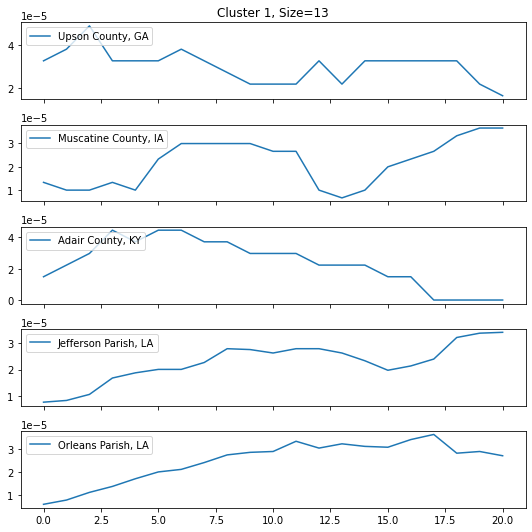

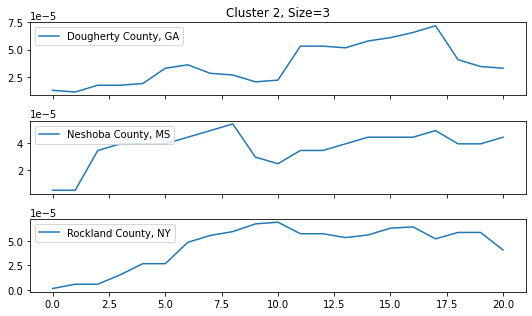

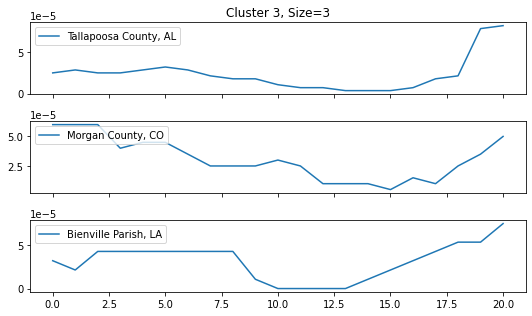

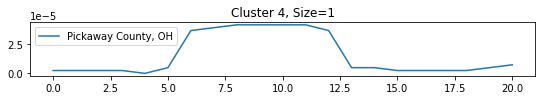

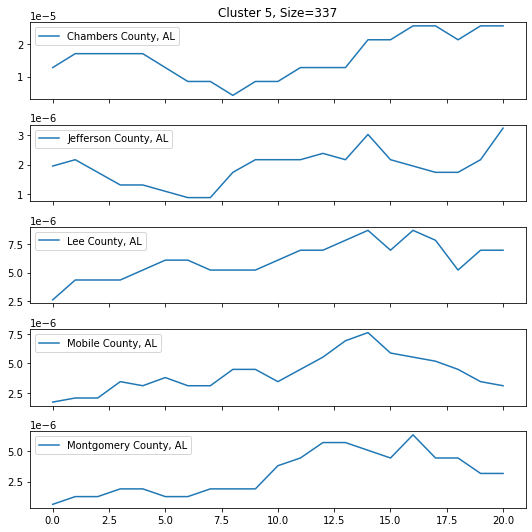

In [210]:
for label in np.unique(clustering.labels_):
    plot(clustering.labels_, label=label, n=5, show=True)

### l2 distance

In [211]:
n_clusters = np.arange(2,10,1)
linkage = 'ward'
for n_clusters in n_clusters:
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage,
        affinity='euclidean'
    ).fit(X)
    score = silhouette_score(X, clustering.labels_, metric='euclidean')
    print(f'{n_clusters}: {score}')

2: 0.5667123082652309
3: 0.5206939890079803
4: 0.3210335450427189
5: 0.3268017782828218
6: 0.3378847702039388
7: 0.34019780925240306
8: 0.3502747803696557
9: 0.3522317001604824


In [212]:
clustering = AgglomerativeClustering(n_clusters=4, linkage=linkage, affinity='euclidean').fit(X)

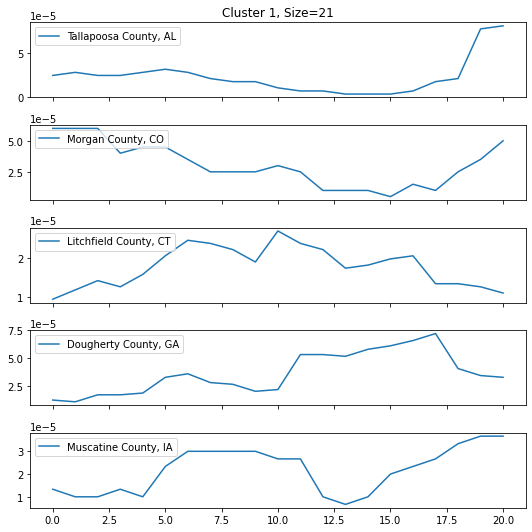

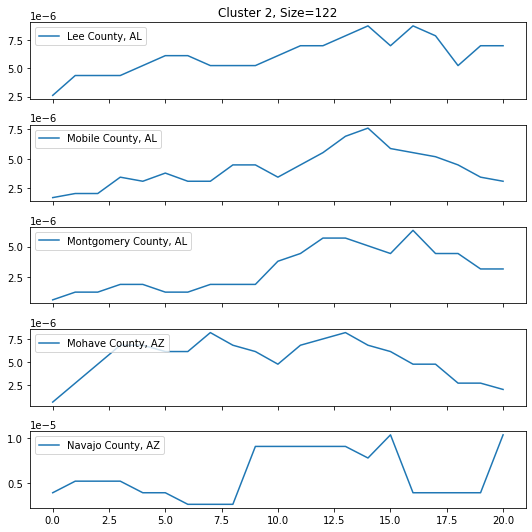

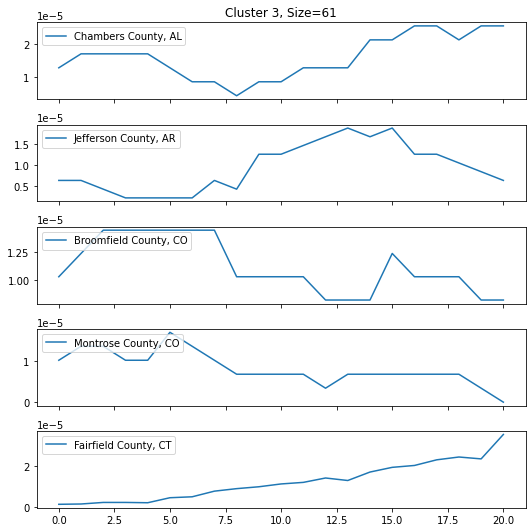

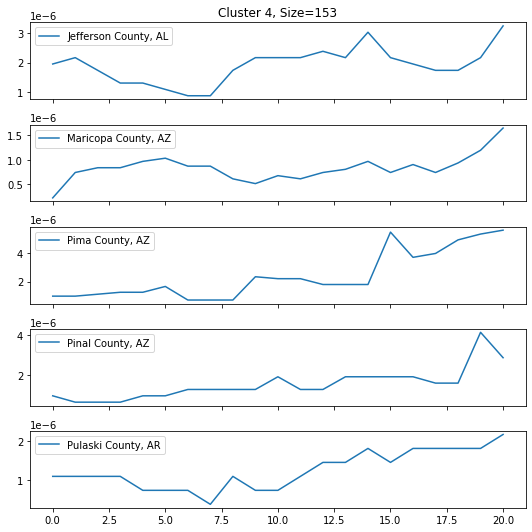

In [213]:
for label in np.unique(clustering.labels_):
    plot(clustering.labels_, label=label, n=5, show=True)

## Normalize shape

In [227]:
X = ddf[days].rolling(
    7, center=True, axis=1
).mean(
).dropna(
    axis=1
).values

X -= X.min(axis=1)[:,None]
X /= X.max(axis=1)[:,None]

y = ddf['FIPS'].values

In [229]:
X_dists = pairwise_distances(X, metric=DTWDistance)

In [230]:
linkage = 'average'
n_clusters = np.arange(2,10,1)
for n_clusters in n_clusters:
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage,
        affinity='precomputed'
    ).fit(X_dists)
    score = silhouette_score(X_dists, clustering.labels_, metric='precomputed')
    print(f'{n_clusters}: {score}')

2: 0.786168909713912
3: 0.44330686636171557
4: 0.40353703251168
5: 0.36441936521977913
6: 0.32519429133385863
7: 0.2547281014564814
8: 0.20967558577284295
9: 0.2434667473808016


In [231]:
clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage, affinity='precomputed').fit(X_dists)

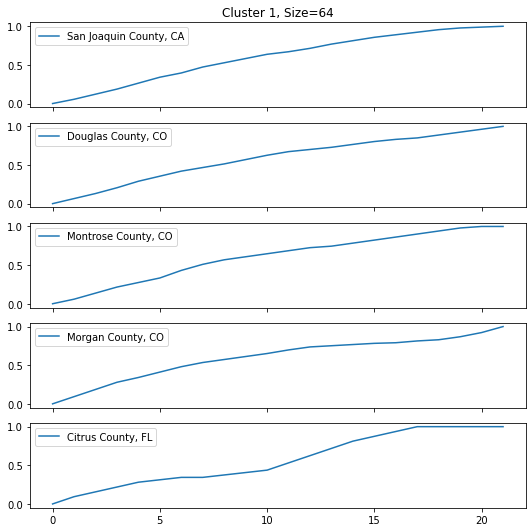

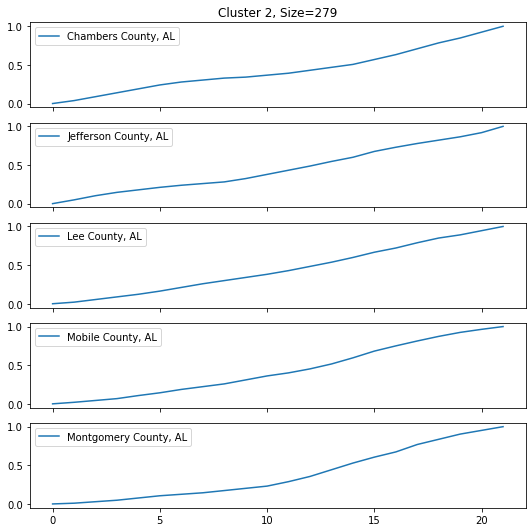

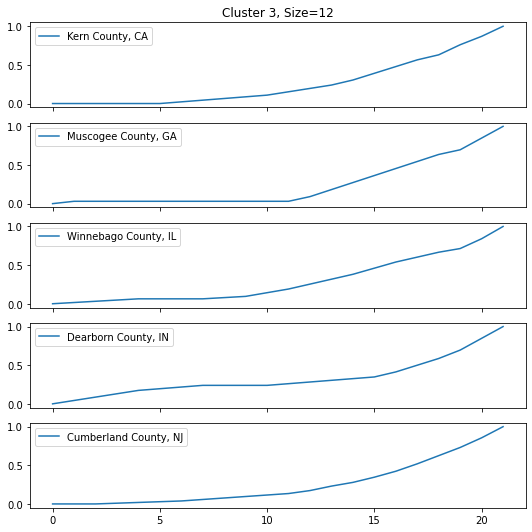

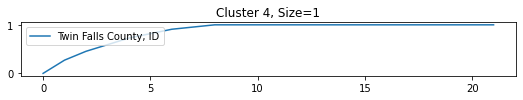

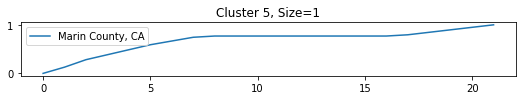

In [232]:
for label in np.unique(clustering.labels_):
    plot(clustering.labels_, label=label, n=5, show=True)

In [233]:
n_clusters = np.arange(2,10,1)
linkage = 'ward'
for n_clusters in n_clusters:
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage,
        affinity='euclidean'
    ).fit(X)
    score = silhouette_score(X, clustering.labels_, metric='euclidean')
    print(f'{n_clusters}: {score}')

2: 0.4470349552357128
3: 0.3068711048496143
4: 0.29244565182182203
5: 0.28276141517991293
6: 0.26429965468948535
7: 0.23445337374308528
8: 0.21932880660497958
9: 0.2306910366632622


In [235]:
clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage, affinity='euclidean').fit(X)

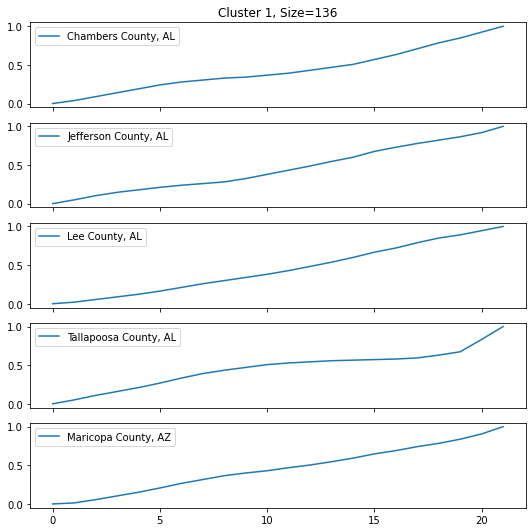

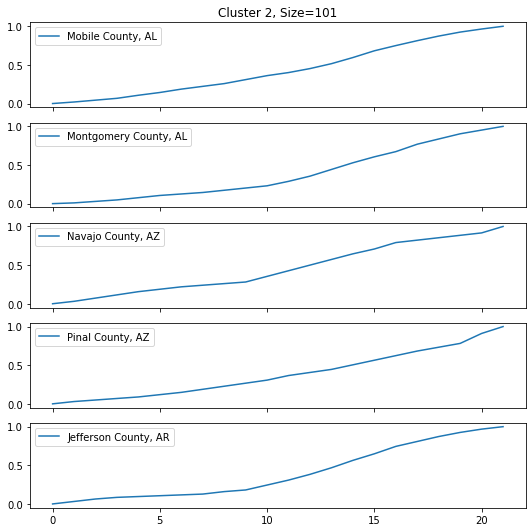

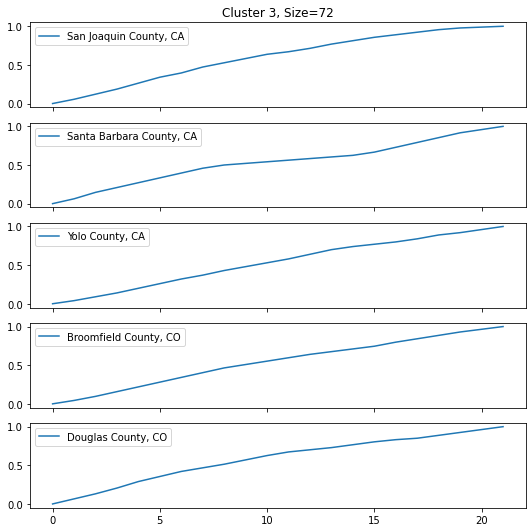

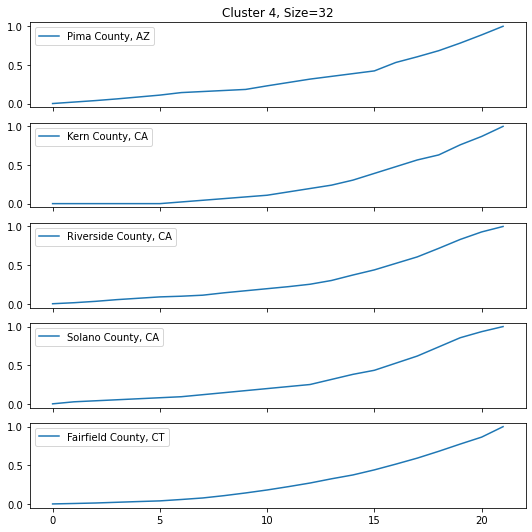

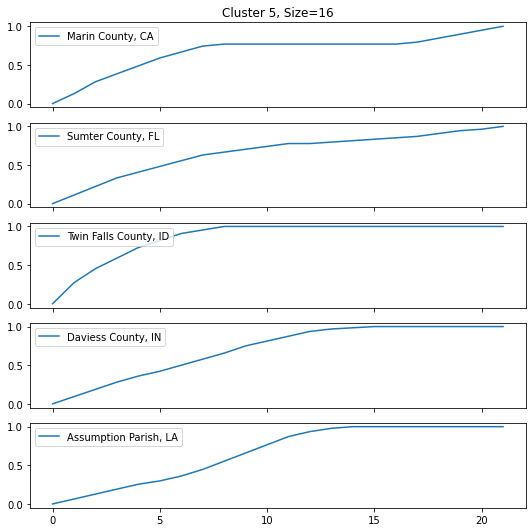

In [236]:
for label in np.unique(clustering.labels_):
    plot(clustering.labels_, label=label, n=5, show=True)